In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
import glob

import numpy as np
import pandas as pd

import scipy.signal as signal
from scipy.signal import medfilt, find_peaks

import efmlib

In [3]:
show_plots = True

## Read data and make an initial plot so we can decide on launch

In [4]:
# Get sonde file
df_sonde = pd.read_csv('/data/LEE/Radiosonde_QC/LEELidar_pyqc20230706171938_20230127_063339.csv', parse_dates=['Time'])

#Get EFM files:
filenames = sorted(glob.glob('/data/LEE/IOP7/Sleet-IOP7/EFM*.TXT'))
df_gps, df_fiber = efmlib.io.read_efm_raw(filenames[:])

<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM00.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM01.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM02.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM03.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM04.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM05.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM06.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM07.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM08.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM09.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM10.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM11.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM12.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-IOP7/EFM13.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP7/Sleet-I

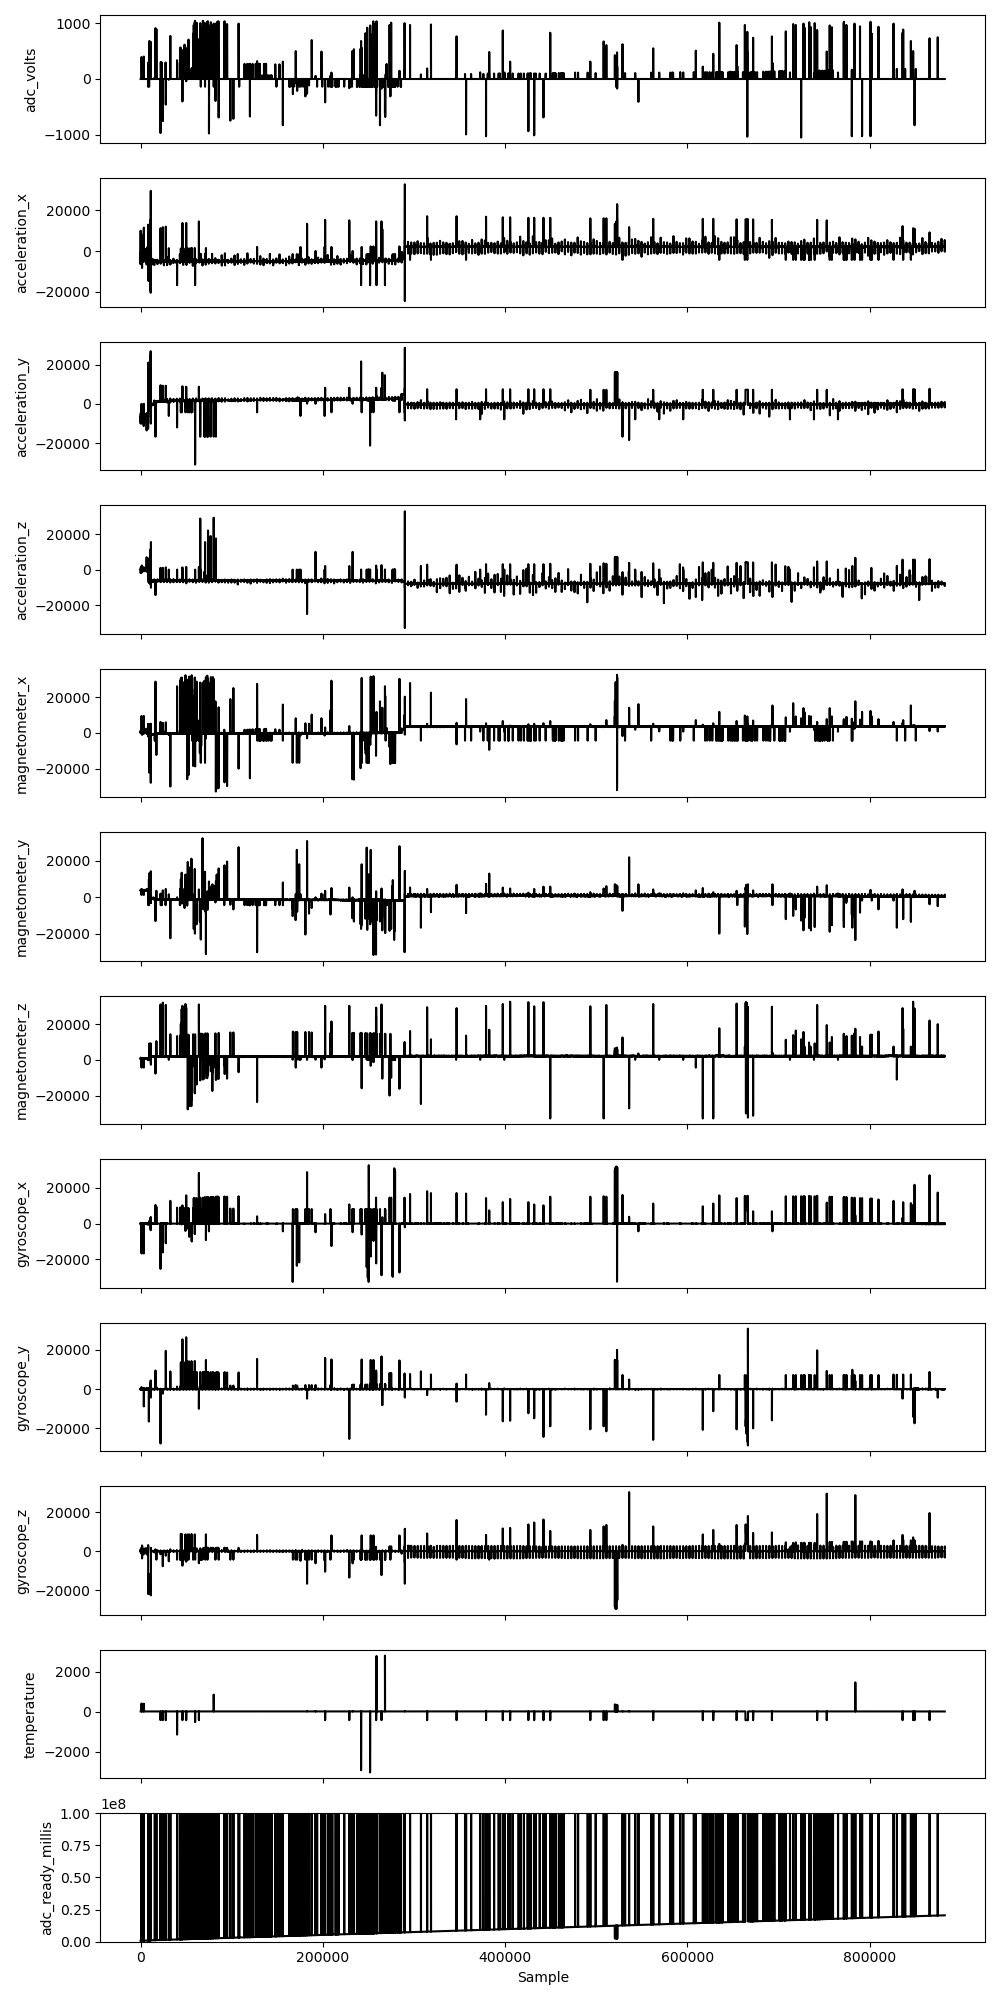

In [5]:
if show_plots == True:
    # print('-> Figures:')
    fields = ['adc_volts', 'acceleration_x', 'acceleration_y', 'acceleration_z',
              'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 
              'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 
              'temperature', 'adc_ready_millis']
    fig, axes = plt.subplots(figsize=(10, 20), nrows=len(fields), sharex=True)
    for fname, ax in zip(fields, axes):
        ax.plot(df_fiber[fname], color='k')
        ax.set_ylabel(fname)
    axes[-1].set_xlabel('Sample')
    fig.tight_layout()
    axes[-1].set_ylim(0, 1e8)

## Mark launch and do sample QC after that time

In [6]:
# Zoom into plot, look for a sudden increase in magnitude in the z-axis accelerometer and magnetomter.
launch_sample = 10965
end_trim = 11350

# y-accelerometer's centrifugal component is also positive, as expected for correct board orientation.
# Missing cal data, but records show board was flipped in late Dec 2022, before this flight. 
board_reversed=False 

In [7]:
df_fiber = efmlib.qc.df_fiber_filter(df_fiber[launch_sample:end_trim].reset_index())                      #Quality control

Removing inserted junk data
indentifying sections that need reconstruction
removing excess samples from reconstructed regions
attempting to reconstruct regions with cosine functions
Removing outlier noise


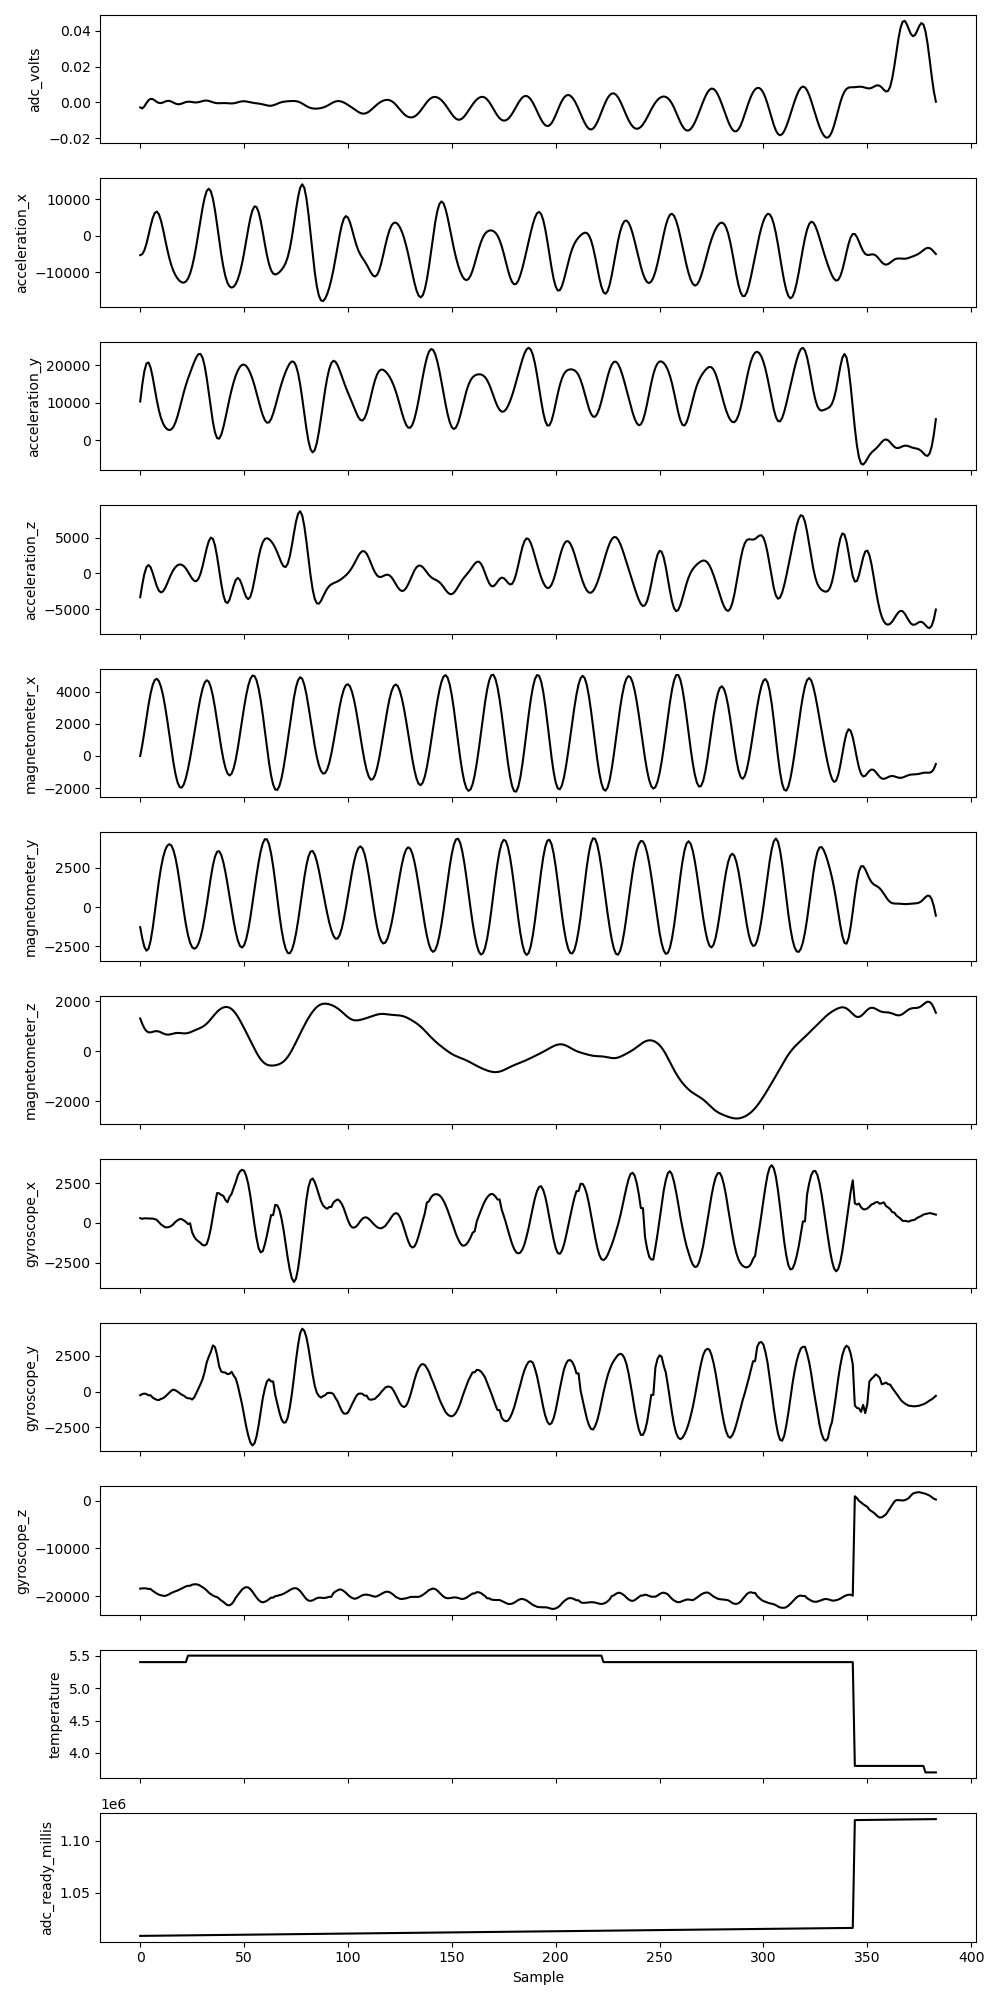

In [8]:
if show_plots == True:
    # print('-> Figures:')
    fields = ['adc_volts', 'acceleration_x', 'acceleration_y', 'acceleration_z',
              'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 
              'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 
              'temperature', 'adc_ready_millis']
    fig, axes = plt.subplots(figsize=(10, 20), nrows=len(fields), sharex=True)
    for fname, ax in zip(fields, axes):
        ax.plot(df_fiber[fname], color='k')
        ax.set_ylabel(fname)
    axes[-1].set_xlabel('Sample')
    fig.tight_layout()
    # axes[0].set_ylim(-1, 1)

In [9]:
# DRAFT: Bandpass filter the accelerometer signals, and then normalize by the total 
# length of the acceleration vector. Will naturally remove the centrifugal component, too. 
# For a quick hack at polarity, also bandpass filter the ADC signal the same way 
# as the acceleromter, then multiply and low pass filter to get a (hopefully slowly varying) polarity signal.

fs = 45.45
f_spin = efmlib.signal.freq_peak(df_fiber['acceleration_x'], fs)[0]
print("Spin rate from peak frequency is ", f_spin)

df_fiber, passband, bp_sos = efmlib.signal.normalize_accelerometer(df_fiber, board_reversed, fs=fs)
# Set the low pass cutoff at the same point as the lower end of the accelerometer passband. It's convenient.
lp_cut = passband[0]
adc_polarity_bp, lp_sos, adc_polarity, adc_sign = efmlib.signal.simplistic_E_polarity(df_fiber, bp_sos, lp_cut, fs=fs)


Spin rate from peak frequency is  2.012109375
Assuming spin frequency of  2.012109375


### Find peak-to-peak E and calibrate it

In [10]:
def find_peak_to_peak(adc, distance=9):
    peak_idx, peak_data         = find_peaks(adc, distance=distance)
    neg_peak_idx, neg_peak_data = find_peaks(-adc, distance=distance)
    n_peaks = min(peak_idx.shape[0], neg_peak_idx.shape[0])

    estimate_idxrange = 0, adc.shape[0]
    
    
    max_idx_critter = (peak_idx >= estimate_idxrange[0]) & (peak_idx < estimate_idxrange[1])
    min_idx_critter = (neg_peak_idx >= estimate_idxrange[0]) & (neg_peak_idx < estimate_idxrange[1])
    target_max_peak = peak_idx[max_idx_critter]
    target_min_peak = neg_peak_idx[min_idx_critter]
    peak_peak_range = (adc[target_max_peak]).max() - (adc[target_min_peak]).min()

    # This is a bad way to match up the peaks, since it assumes that there is an alternating set of positive
    # and negative peaks, instead of matching them by index.
    peak_peak_range = adc[peak_idx[:n_peaks]] - adc[neg_peak_idx[:n_peaks]]

    print('Number of peak samples:',peak_peak_range.shape[0])
    
    return peak_idx[:n_peaks], neg_peak_idx[:n_peaks], peak_peak_range

In [11]:
#Now extract peak voltages to separate array:
#------
# This is not ideal, but max of maxes minus min of mins is an ok estimate of the peak to peak voltage.

adc_samples = df_fiber['adc_volts'].values

peak_idx, neg_peak_idx, peak_peak_range = find_peak_to_peak(adc_samples)
E_calibrated_mag = efmlib.calibration.calibrated_E(peak_peak_range)

Number of peak samples: 19


Displaying Peaks of raw voltage source (interpolated).


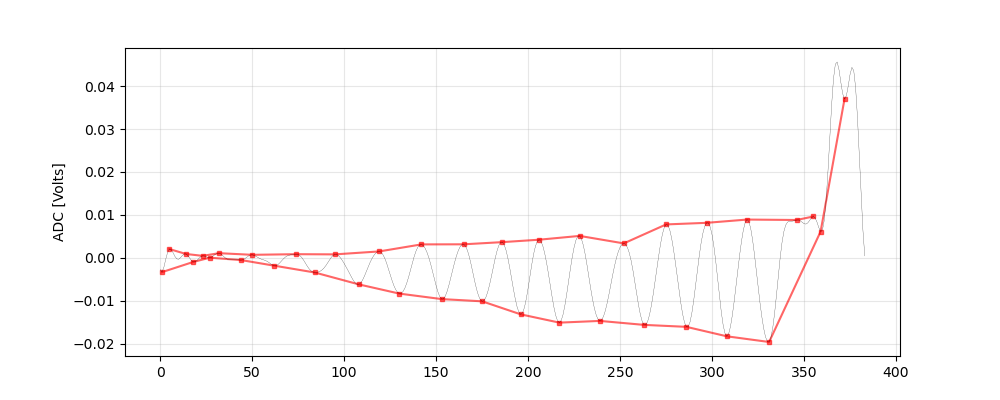

In [12]:
#Plot raw voltage signal with identified peaks (red)
#---------
print('Displaying Peaks of raw voltage source (interpolated).')
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(peak_idx, adc_samples[peak_idx], 
        color='r', marker='s', linewidth=None, markersize=3,alpha=0.6)
ax.plot(neg_peak_idx, adc_samples[neg_peak_idx], 
        color='r', marker='s', linewidth=None, markersize=3,alpha=0.6)

ax.plot(adc_samples, color='k', marker=None, linewidth=.2, markersize=2,alpha=0.8)
ax.set_ylabel('ADC [Volts]')
ax.grid(alpha=0.3)

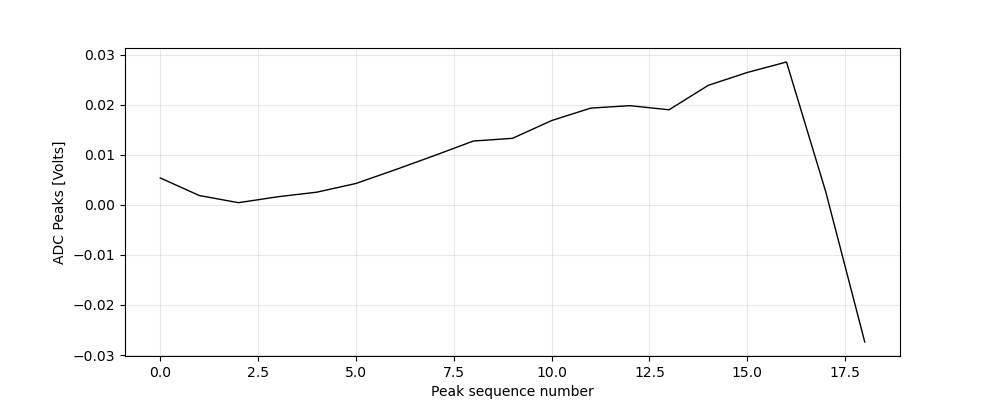

In [13]:
#Plot voltage peaks only:
#-------
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(peak_peak_range,color='k',linewidth=1)
ax.set_xlabel('Peak sequence number')
ax.set_ylabel('ADC Peaks [Volts]')
ax.grid(alpha=0.3)

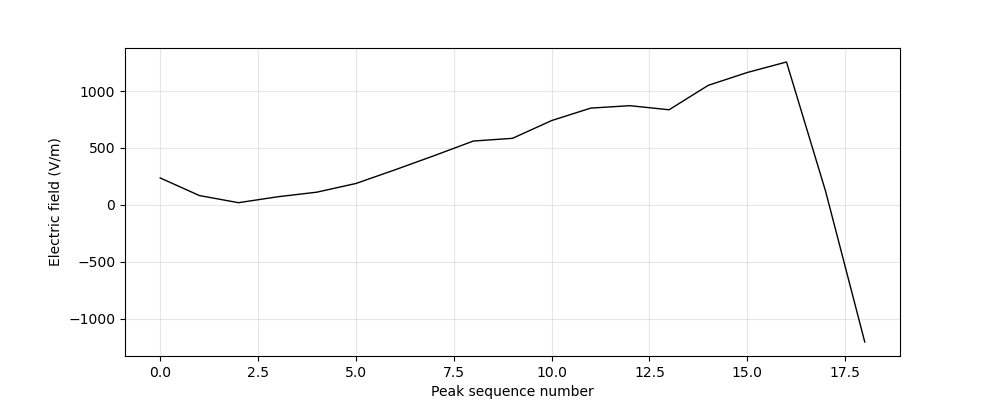

In [14]:
#Plot calibrated voltage to electric field signal:
#-------
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(E_calibrated_mag,color='k',linewidth=1)
ax.set_xlabel('Peak sequence number')
ax.set_ylabel('Electric field (V/m)')
ax.grid(alpha=0.3)

In [15]:
max_E = np.empty_like(adc_samples)*np.nan

# use the average of the peak indices as the representative sample for the peak-to-peak E.
max_E_idx = ((peak_idx+neg_peak_idx)/2.0).astype(int)

max_E[max_E_idx] = E_calibrated_mag

# Would be nice to LPF interpolate here before assigning back.
df_fiber['max_E'] = max_E * adc_sign

## Align EFM and sonde data

In [16]:
df_fiber.columns

Index(['index', 'start_byte', 'adc_ready_millis', 'adc_reading',
       'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'temperature', 'relative_humidity', 'pressure',
       'end_byte', 'adc_volts', 'acceleration_x_bp', 'acceleration_y_bp',
       'acceleration_z_bp', 'max_E'],
      dtype='object')

In [17]:
sonde_time_var = 'Time'
launch_time = df_sonde[sonde_time_var].values[0]
df_fiber[sonde_time_var]= launch_time + (df_fiber.adc_ready_millis - df_fiber.adc_ready_millis[0]).values.astype('timedelta64[ms]')

In [18]:
# Resample EFM data to 1 s
df_EFMsecond = df_fiber.set_index('Time').fillna(method='ffill').resample('1s').max()
df_merged = df_sonde.set_index('Time')
df_merged['max_E'] = df_EFMsecond.max_E

df_merged['T_C'] = df_merged['Filtered Temperature (K)'] - 273.15
df_merged['Td_C'] = df_merged['Filtered Dewpoint (K)'] - 273.15
df_merged['alt_km'] = df_merged['Filtered Altitude (m)']/1000.0

# df_merged

In [19]:
from scipy.ndimage import uniform_filter

E_smoothed = uniform_filter(df_merged.max_E, 5)

raw_charge_density = 8.854e-12*np.gradient(E_smoothed, df_merged.alt_km*1000)
charge_density_nCm3 = np.abs(
    uniform_filter(raw_charge_density * 1e9, 7)
)

Text(0.5, 0, 'Charge density\n(nC/m$^3$)')

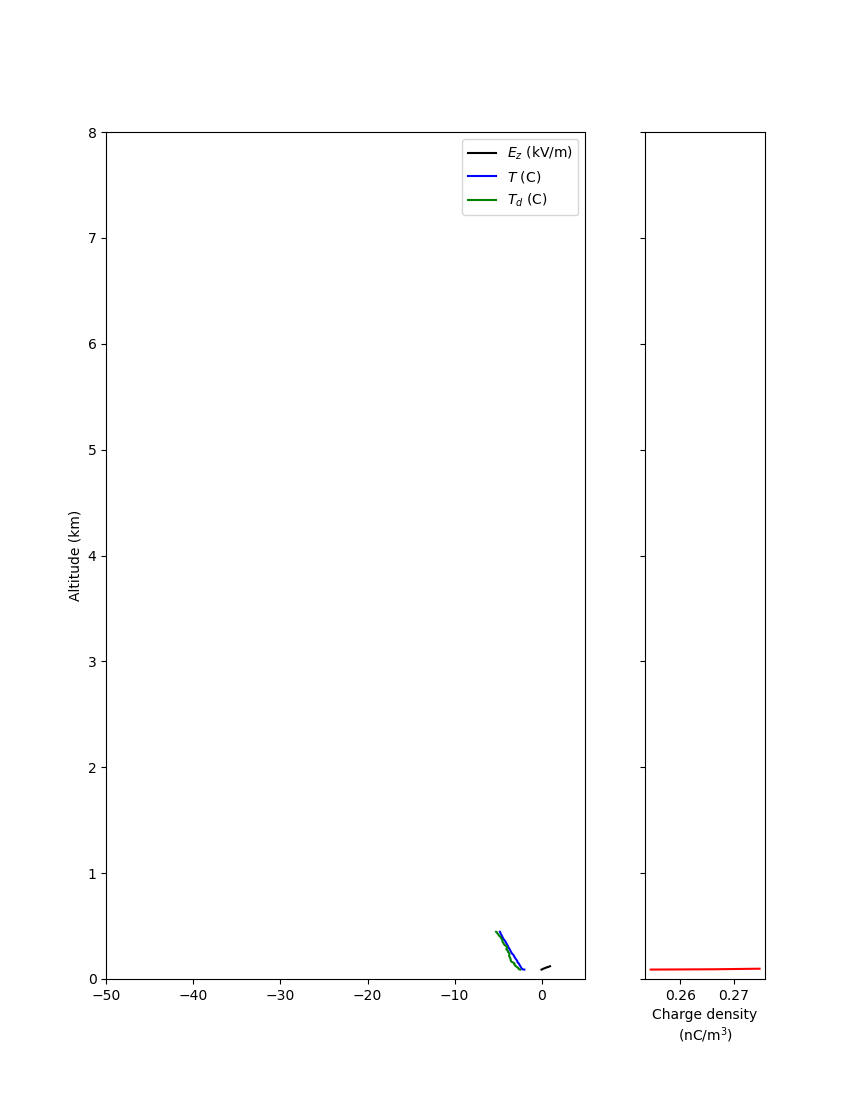

In [20]:
fig, (ax, ax_rho) = plt.subplots(1,2, figsize=(8.5, 11), 
                                 gridspec_kw={'width_ratios': [0.8, 0.2]}, sharey=True)
ax.plot(E_smoothed/1000.0, df_merged.alt_km, color='k', label='$E_z$ (kV/m)')
ax.plot(df_merged.T_C, df_merged.alt_km, color='b', label='$T$ (C)')
ax.plot(df_merged.Td_C, df_merged.alt_km, color='g', label='$T_d$ (C)')
ax.legend()
ax.set_xlim(-50,5)
ax.set_ylim(0, 8)
ax.set_ylabel('Altitude (km)')

ax_rho.plot(charge_density_nCm3, df_merged.alt_km, color='r')
ax_rho.set_xlabel('Charge density\n(nC/m$^3$)')

# Plot the of phase offset between ADC and a_x, a_y.

We expect the two accelerometer channels to be 90° out of phase by design.

The y channel of the accelerometer should be either 0° or 180° in phase with spin, since 
https://github.com/LeemanGeophysicalLLC/NSSL_EFM/issues/71

In level flight, therefore, a_y should be fully in phase with the ADC (with sign depending on the orientation of the circuit board's installation). This is not what we find.

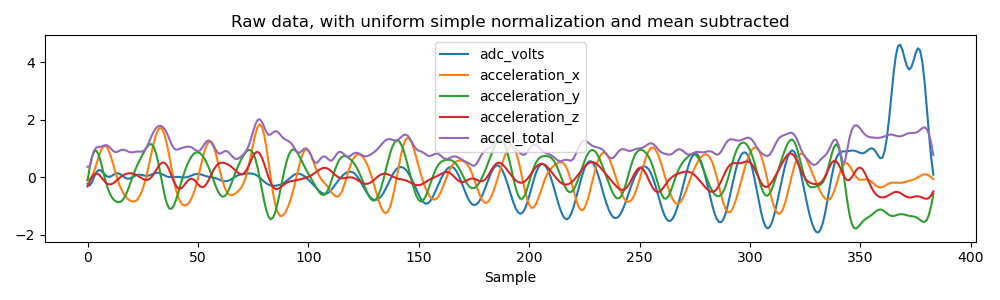

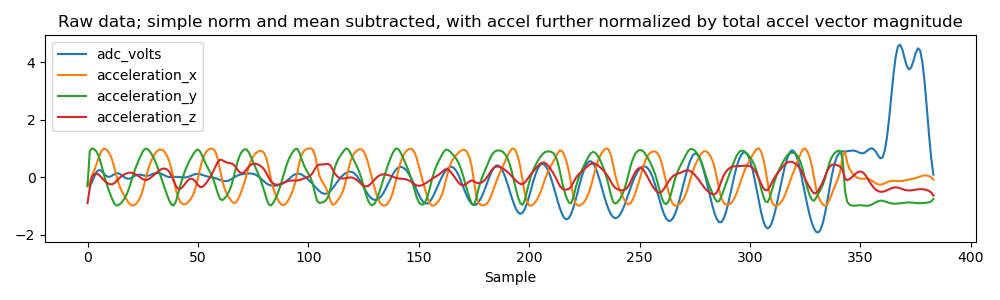

In [21]:
accel_total = np.sqrt(df_fiber.acceleration_x**2 + (df_fiber.acceleration_y-df_fiber.acceleration_y.mean())**2 + df_fiber.acceleration_z**2)

if show_plots == True:
    # print('-> Figures:')
    fields = ['adc_volts', 'acceleration_x', 'acceleration_y', 
              'acceleration_z',
              #'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 
              #'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 
              #'temperature', 'adc_ready_millis'
             ]
    # amplitude (not peak to peak)
    ranges = {'adc_volts':0.01,
              'acceleration_x':10000,
              'acceleration_y':10000,
              'acceleration_z':10000,
             }
    sum_sq_accel = None
    fig, ax = plt.subplots(1,1, figsize=(10,3))
    for fname in fields:
        mean = df_fiber[fname].mean()
        data = (df_fiber[fname]-mean)/ranges[fname]
        ax.plot(data, label=fname)
        if 'accel' in fname:
            if sum_sq_accel is None:
                sum_sq_accel = (data*data)
            else:
                sum_sq_accel += (data*data)
    ax.plot(np.sqrt(sum_sq_accel), label='accel_total')
    ax.set_xlabel('Sample')
    ax.legend()
    ax.set_title('Raw data, with uniform simple normalization and mean subtracted')
    fig.tight_layout()
    
    fig, ax = plt.subplots(1,1, figsize=(10,3))
    for fname in fields:
        mean = df_fiber[fname].mean()
        if 'accel' in fname:
            data = (df_fiber[fname]-mean)/ranges[fname] / np.sqrt(sum_sq_accel)
        else:
            # ADC
            data = (df_fiber[fname]-mean)/ranges[fname] 
        ax.plot(data, label=fname)
    ax.set_xlabel('Sample')
    ax.legend()
    ax.set_title('Raw data; simple norm and mean subtracted, with accel further normalized by total accel vector magnitude')
    fig.tight_layout()

    # axes[0].set_ylim(-1, 1)

Looks like removing the mean (which removes the centrifugal term from ay) and normalizing by total magnitude gets us close to a reference signal.

So we can apply a bandpass filter centered at the spin frequency to see if that cleans up some of the wobbliness of ax and ay. 

### Determine where E polarity changes by comparing to the acceleration_y channel.

Bandpass filter the accelerometer signals, and then normalize by the total length of the acceleration vector. Will naturally remove the centrifugal component, too. For a quick hack at polarity, also bandpass filter the ADC signal the same way as the acceleromter, then multiply and low pass filter to get a (hopefully slowly varying) polarity signal. Uses the results calculated above.

/var/folders/7g/hkpr1fzx7w92t_lj0lg5jmzm0000gn/T/ipykernel_53780/1199019050.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)))


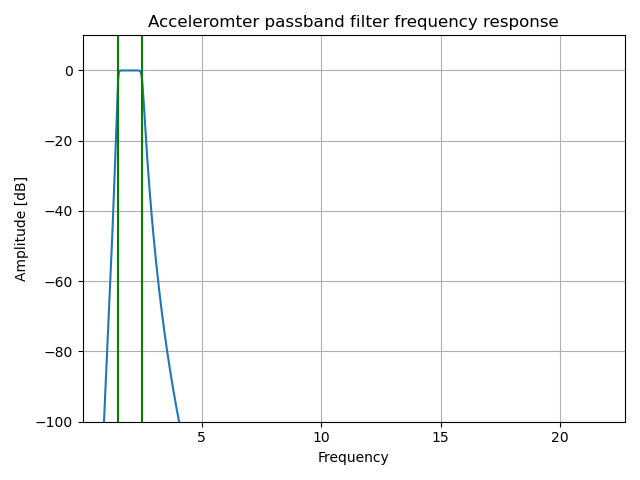

In [22]:
if show_plots:
    w, h = signal.sosfreqz(bp_sos, worN=1024, fs=fs)
    plt.figure()
    # plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.plot(w, 20 * np.log10(abs(h)))
    plt.title('Acceleromter passband filter frequency response')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.ylim(-100, 10)
    for pb in passband:
        plt.axvline(pb, color='green') # cutoff frequency
    plt.tight_layout()

Plot again, checking assuming accelerometer data have been normalized. Scale ADC since it won't be in -1 to 1 naturally.

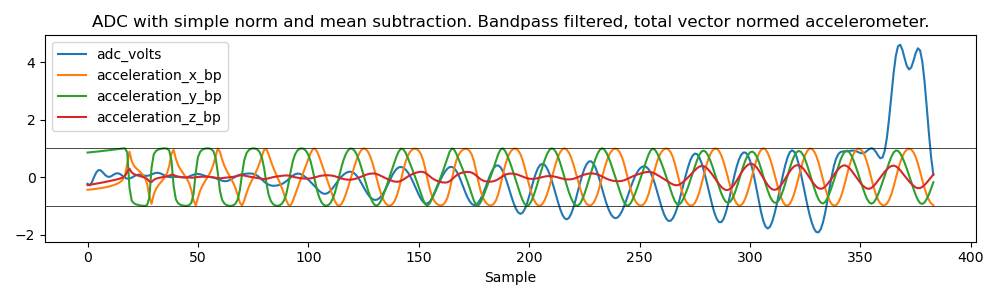

In [23]:
if show_plots:
    fields = ['adc_volts', 'acceleration_x_bp', 'acceleration_y_bp', 
              'acceleration_z_bp',
              #'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 
              #'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 
              #'temperature', 'adc_ready_millis'
             ]
    # amplitude (not peak to peak)
    ranges = {'adc_volts':0.01,
              'acceleration_x_bp':1,
              'acceleration_y_bp':1,
              'acceleration_z_bp':1,
             }

    fig, ax = plt.subplots(1,1, figsize=(10,3))
    for fname in fields:
        mean = df_fiber[fname].mean()
        if 'accel' in fname:
            data = df_fiber[fname]
        else:
            # ADC
            data = (df_fiber[fname]-mean)/ranges[fname] 
        ax.plot(data, label=fname)
    ax.set_xlabel('Sample')
    ax.set_title('ADC with simple norm and mean subtraction. Bandpass filtered, total vector normed accelerometer.')
    ax.axhline(1, lw=.5, color='k')
    ax.axhline(-1, lw=.5, color='k')
    ax.legend()

    fig.tight_layout()


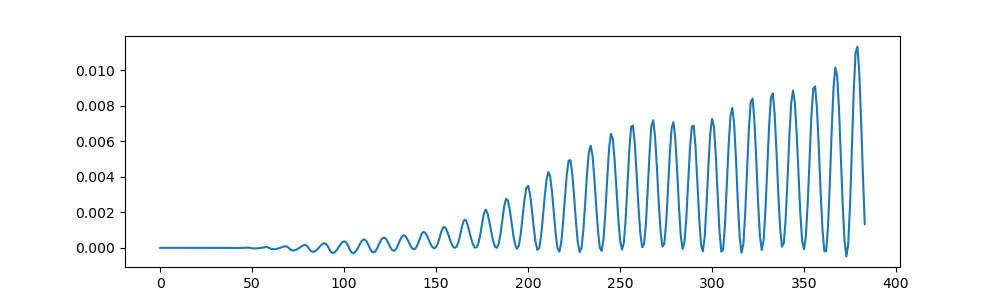

In [24]:
if show_plots:
    plt.figure(figsize=(10,3))
    (adc_polarity_bp * df_fiber['acceleration_y_bp']).plot()

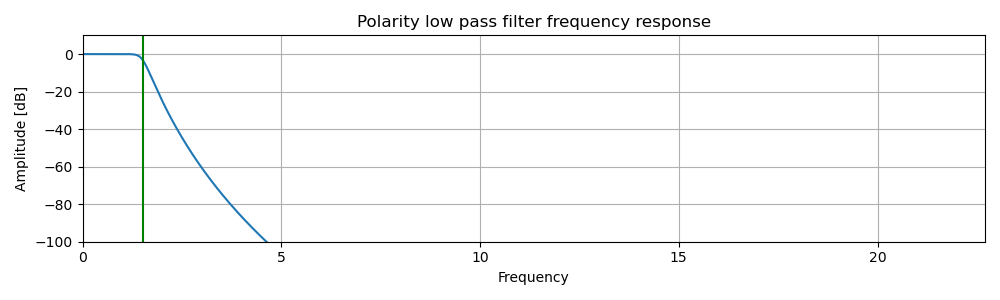

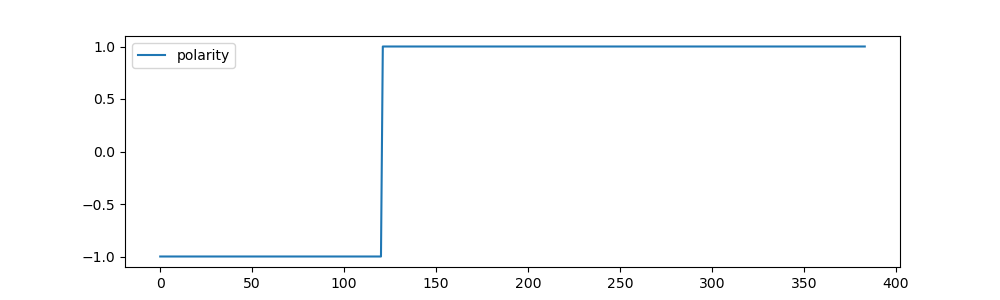

In [25]:
if show_plots:
    w, h = signal.sosfreqz(lp_sos, worN=1024, fs=fs)
    # b, a = signal.butter(10, passband[0], 'lp', analog=True)
    # w, h = signal.freqs(b, a)
    plt.figure(figsize=(10,3))
    # plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.plot(w, 20 * np.log10(abs(h)))
    plt.title('Polarity low pass filter frequency response')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.ylim(-100, 10)
    plt.axvline(lp_cut, color='green') # cutoff frequency
    plt.tight_layout()


    plt.figure(figsize=(10,3))
    plt.plot(np.sign(adc_polarity), label='polarity')
    plt.legend()